In [38]:
from sudoku import Sudoku, SudokuGenerator
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
import os
import time

# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")



Using MPS (Apple Silicon)
Device: mps


# HYPERPARAMETERS

In [ ]:
N_EPOCHS = 150
LEARNING_RATE = 0.001
ATTENTION_DIM = 2
N_HEADS = 8
EMBEDDING_DIM = 8
TRAIN_PUZZLES = 10000
VAL_PUZZLES = 512
BATCH_SIZE = 512
VALIDATE_PERIOD = 10  # Run validation every N epochs
CHECKPOINT_PERIOD = 10  # Save checkpoint every N epochs
CHECKPOINT_DIR = "./sudoku_checkpoints"  # Directory to save checkpoints
LOAD_CHECKPOINT = None  # Path to checkpoint to load, or None to start fresh
SAVE_CHECKPOINT = True
SAMPLES_PER_PUZZLE = 2

assert ATTENTION_DIM % N_HEADS == 0

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def get_checkpoint_filename(epoch=None):
    """Generate checkpoint filename with hyperparameters"""
    filename = f"sudoku_emb{EMBEDDING_DIM}_att{ATTENTION_DIM}_h{N_HEADS}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"
    if epoch is not None:
        filename += f"_epoch{epoch}"
    else:
        filename += "_final"
    filename += ".pt"
    return os.path.join(CHECKPOINT_DIR, filename)


In [ ]:
class PositionalEncoding(nn.Module):
    # for a 9 by 9 sudoku grid
    # subdivide a unit circle into 81 sections
    # and return x, y coordinates of that output
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        # Create a grid of positions (0-8 for both x and y)
        x_coords = torch.arange(0, 9).unsqueeze(0).repeat(9, 1)
        y_coords = torch.arange(0, 9).unsqueeze(1).repeat(1, 9)
        
        # Convert grid positions to linear indices (0-80)
        linear_indices = y_coords * 9 + x_coords  # shape: (9, 9)
        
        # Convert linear indices to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (9, 9)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles)
        y_circle = torch.sin(angles)
        
        # Stack and add batch dimension
        pos_encoding = torch.stack([x_circle, y_circle], dim=-1).unsqueeze(0)  # shape: (1, 9, 9, 2)
        self.register_buffer('pos_encoding', pos_encoding)
    
    def get_embedding_for_position(self, pos):
        # input (batch, 2) where pos[:, 0] is x and pos[:, 1] is y
        # Convert to linear indices
        linear_indices = pos[:, 1] * 9 + pos[:, 0]  # shape: (batch,)
        
        # Convert to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (batch,)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles).unsqueeze(1)  # shape: (batch, 1)
        y_circle = torch.sin(angles).unsqueeze(1)  # shape: (batch, 1)
        
        return torch.cat([x_circle, y_circle], dim=1)  # shape: (batch, 2)
    
    def forward(self, x):
        # x is a (batch, 9, 9, embedding_dim) grid
        # output (batch, 9, 9, embedding_dim + 2) grid by adding pos_encoding to x
        batch_size = x.shape[0]
        pos_expanded = self.pos_encoding.repeat(batch_size, 1, 1, 1)
        # Concatenate along the last dimension: (batch, 9, 9, embedding_dim + 2)
        return torch.cat([x, pos_expanded], dim=-1)
    

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # seperate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3) # [batch, head, seqlen, dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0,2,1,3) # [batch, seqlen, head, dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values) # [batch, seq_length, 81]

        if return_attention:
            return o, attention
        else:
            return o


In [ ]:
class Sudoku2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, attention_dim=ATTENTION_DIM, num_heads=N_HEADS, device='cpu'):
        super(Sudoku2Vec, self).__init__()
        self.device = device
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        self.pe = PositionalEncoding()
        self.embed = nn.Embedding(vocab_size, embedding_dim) # this will provide the key queries and values
        self.total_dim = self.embedding_dim + 2

        self.mha = MultiheadAttention(
            input_dim=self.total_dim,
            embed_dim=attention_dim,
            num_heads=num_heads
        )
        
        # Move model to device BEFORE compiling (critical for GPU!)
        self.to(device)
        
        if hasattr(torch, 'compile'):
            self.mha = torch.compile(self.mha, mode='max-autotune')
    
    def forward(self, target, position, sudoku_grid, mask=True):
        # target - the token in the target blank space we try to predict shape [batch] i.e [0, 3, 3, 5, 1, ...]
        # position - the (x, y) position of the target shape [batch, 2] - [[1, 1], [0, 3], [7,7], ...]
        # sudoku_grid - the sudoku grid for the problem with target we want to predict shape [batch, 9, 9]
        batch_size = target.shape[0]
        
        target_token_embeddings = self.embed(target) # shape [batch, embedding_dim]
        target_position_vectors = self.pe.get_embedding_for_position(position) # [batch, 2]
        target_token_with_position = torch.cat([target_token_embeddings, target_position_vectors], dim=-1)  # shape [batch, total_dim]

        # mask the target in the grid
        sudoku_grid_masked = sudoku_grid
        if mask:
            batch_indices = torch.arange(sudoku_grid.shape[0], device=self.device)
            sudoku_grid_masked = sudoku_grid.clone()
            sudoku_grid_masked[batch_indices, position[:, 1], position[:, 0]] = 0 # 0 is a mask token aka blank
        
        masked_sudoku_grid_embeddings = self.embed(sudoku_grid_masked)
        masked_sudoku_grid_with_position = self.pe(masked_sudoku_grid_embeddings) # shape [batch, 9, 9, total_dim]
        # Reshape grid to sequence: [batch, 81, total_dim]
        masked_grid_seq = masked_sudoku_grid_with_position.view(batch_size, 81, self.total_dim)

        grid_seq_embeddings = self.embed(sudoku_grid)
        grid_seq_embeddings = grid_seq_embeddings.view(batch_size, 81, self.embedding_dim) 
        
        # Query from target token: [batch, 1, total_dim]
        # query = target_token_with_position.unsqueeze(1)

        output, attention = self.mha(masked_grid_seq, return_attention=True)
        # output is shape [batch, 81, total_dim]
        
        return output, attention, target_token_with_position, grid_seq_embeddings
    
    def loss(self, target, position, sudoku_grid, negative_samples=2):
        """
        Compute contrastive loss for the model.
        
        The loss combines two components:
        1. InfoNCE Contrastive Loss: Encourages the model to distinguish between correct (positive) 
           and incorrect (negative) token predictions using a softmax-based ranking objective.
        2. Cosine Similarity Loss: Directly maximizes the cosine similarity between predicted and 
           ground truth embeddings.
        
        Mathematical formulation:
        
        For a batch of examples, let:
        - z_i = output embedding at target position i
        - p_i = ground truth embedding at position i
        - n_{i,j} = j-th negative sample embedding for example i
        
        Cosine Similarity:
            cos_sim(z_i, p_i) = (z_i · p_i) / (||z_i|| ||p_i||)
        
        InfoNCE Loss (per example i):
            L_contrastive = -log( exp(cos_sim(z_i, p_i) / τ) / 
                                  (exp(cos_sim(z_i, p_i) / τ) + Σ_j exp(cos_sim(z_i, n_{i,j}) / τ)) )
        
        where τ is a temperature parameter (0.07) that controls the concentration of the distribution.
        
        Cosine Loss:
            L_cosine = 1 - mean(cos_sim(z_i, p_i))
        
        Total Loss:
            L_total = L_contrastive + L_cosine
        
        Relationship between the two losses:
        - Both losses encourage high cosine similarity between predicted and ground truth embeddings
        - L_contrastive uses a ranking objective: it ensures the positive similarity is higher than 
          negative similarities through a softmax normalization
        - L_cosine provides a direct gradient signal to maximize positive similarity without 
          considering negatives
        - L_contrastive is scale-invariant (only cares about relative similarities) while L_cosine 
          provides absolute magnitude information
        - Together, they provide both relative ranking (contrastive) and absolute alignment (cosine)
        
        Args:
            target: Ground truth tokens [batch]
            position: Target positions [batch, 2]
            sudoku_grid: Sudoku grids [batch, 9, 9]
            negative_samples: Number of negative samples per positive example
        
        Returns:
            total_loss: Combined loss value
            contrastive_loss: InfoNCE contrastive loss component
            cosine_loss: Cosine similarity loss component
            accuracy: Prediction accuracy based on closest cosine similarity to vocab embeddings
        """
        batch_size = target.shape[0]
        
        # Forward pass to get output and target embeddings
        output, attention, target_token_with_position, grid_embeddings_flat = self.forward(target, position, sudoku_grid, mask=True)
        # output is shape [batch, seq_length, total_dim]
        
        # Extract only the embedding portion (without position vectors) from output
        # output is [batch, 81, total_dim] where total_dim = embedding_dim + 2
        # We want only the first embedding_dim dimensions
        output_embeddings = output[:, :, :self.embedding_dim]  # shape [batch, 81, embedding_dim]
        
        # Normalize embeddings for cosine similarity computation
        output_norm = F.normalize(output_embeddings, p=2, dim=-1)  # [batch, 81, embedding_dim]
        grid_norm = F.normalize(grid_embeddings_flat, p=2, dim=-1)  # [batch, 81, embedding_dim]
        
        # Compute positive cosine similarity (between output and grid embeddings)
        # This is cos_sim(z_i, p_i) for all positions
        positive_scores = (output_norm * grid_norm).sum(dim=-1)  # [batch, 81]
        positive_scores = positive_scores.mean(dim=-1)  # [batch] - average over all positions

        # === Negative sampling for contrastive loss ===
        # Extract output embeddings at target positions for negative comparison
        batch_indices = torch.arange(batch_size, device=self.device)
        # Convert 2D positions to linear indices
        linear_indices = position[:, 1] * 9 + position[:, 0]  # [batch]
        # Get output embeddings at target positions (z_i)
        output_at_target = output_embeddings[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        output_at_target_norm = F.normalize(output_at_target, p=2, dim=-1)  # [batch, embedding_dim]
        
        # Generate negative samples (n_{i,j})
        # Sample random tokens that are not the target
        vocab_size = self.embed.num_embeddings
        negative_targets = []
        for i in range(batch_size):
            # Sample negative_samples tokens different from target[i]
            neg_samples = []
            while len(neg_samples) < negative_samples:
                neg_token = torch.randint(0, vocab_size, (1,), device=self.device)
                if neg_token.item() != target[i].item():
                    neg_samples.append(neg_token)
            negative_targets.append(torch.cat(neg_samples))
        negative_targets = torch.stack(negative_targets)  # [batch, negative_samples]
        
        # Get embeddings for negative samples (only the embedding part, no position)
        negative_embeddings = self.embed(negative_targets)  # [batch, negative_samples, embedding_dim]
        
        # Compute cosine similarity between output at target position and negative samples
        # This is cos_sim(z_i, n_{i,j})
        output_at_target_norm_expanded = output_at_target_norm.unsqueeze(1)  # [batch, 1, embedding_dim]
        negative_norm = F.normalize(negative_embeddings, p=2, dim=-1)  # [batch, negative_samples, embedding_dim]
        negative_scores = (output_at_target_norm_expanded * negative_norm).sum(dim=-1)  # [batch, negative_samples]
        
        # === InfoNCE Contrastive Loss ===
        # Concatenate positive and negative scores
        all_scores = torch.cat([positive_scores.unsqueeze(1), negative_scores], dim=1)  # [batch, 1 + negative_samples]
        
        # Apply temperature scaling: scores / τ
        temperature = 0.07
        all_scores = all_scores / temperature
        
        # The positive sample is at index 0
        labels = torch.zeros(batch_size, dtype=torch.long, device=self.device)
        
        # Cross entropy loss computes: -log(exp(positive_score) / sum(exp(all_scores)))
        contrastive_loss = F.cross_entropy(all_scores, labels)
        
        # === Cosine Similarity Loss ===
        # Simple loss: 1 - cosine similarity (encourages similarity to approach 1)
        cosine_loss = (1 - positive_scores).mean()
        
        # === Combine both losses ===
        # The contrastive loss ensures relative ranking (positive > negatives)
        # The cosine loss ensures absolute alignment (positive → 1)
        total_loss = contrastive_loss + cosine_loss
        
        # === Compute Accuracy ===
        # For each example in the batch, find which token embedding has highest cosine similarity
        # with the output embedding at the target position
        
        # Get all token embeddings from the embedding layer [vocab_size, embedding_dim]
        all_token_embeddings = self.embed.weight  # [vocab_size, embedding_dim]
        all_token_embeddings_norm = F.normalize(all_token_embeddings, p=2, dim=-1)  # [vocab_size, embedding_dim]
        
        # Compute cosine similarity between output at target and all vocab tokens
        # output_at_target_norm: [batch, embedding_dim]
        # all_token_embeddings_norm: [vocab_size, embedding_dim]
        # We want: [batch, vocab_size]
        similarity_to_all_tokens = torch.matmul(output_at_target_norm, all_token_embeddings_norm.T)  # [batch, vocab_size]
        
        # Get the predicted token (argmax of cosine similarities)
        predicted_tokens = torch.argmax(similarity_to_all_tokens, dim=-1)  # [batch]
        
        # Compute accuracy
        correct_predictions = (predicted_tokens == target).float()
        accuracy = correct_predictions.mean()
        
        return total_loss, contrastive_loss, cosine_loss, accuracy


# TRAIN

In [ ]:

model = Sudoku2Vec(vocab_size=10, embedding_dim=EMBEDDING_DIM, device=device)

# Convert model to bfloat16 if supported for better performance and memory efficiency
if device.type == 'cuda' and torch.cuda.is_bf16_supported():
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16")
elif device.type == 'cpu':
    # Modern CPUs support bfloat16
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16 (CPU)")
else:
    print("✓ Model kept in float32 (bfloat16 not supported)")

# Enable cuDNN benchmarking for CUDA (auto-tunes convolution algorithms)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmarking enabled")

# Create optimizer with fused option if on CUDA for better performance
try:
    if device.type == 'cuda':
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, fused=True)
        print("✓ Using fused Adam optimizer for CUDA")
    else:
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        print("✓ Using standard Adam optimizer")
except:
    # Fallback if fused is not supported
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    print("✓ Using standard Adam optimizer (fused not available)")

✓ Using standard Adam optimizer


In [ ]:
# Compile the model for faster execution using PyTorch 2.0+ torch.compile
# This can significantly speed up training and inference
try:
    # Check PyTorch version
    pytorch_version = tuple(int(x) for x in torch.__version__.split('.')[:2])
    
    if pytorch_version >= (2, 0):
        print(f"PyTorch version {torch.__version__} detected. Attempting to compile model...")
        
        # For MPS (Apple Silicon), use 'default' backend
        # For CUDA, can also try 'inductor' or 'cudagraphs' for better performance
        if device.type == 'mps':
            # MPS has limited compile support, so we use reduce-overhead mode
            compiled_model = torch.compile(model, mode='reduce-overhead')
            print("✓ Model compiled successfully with 'reduce-overhead' mode for MPS")
        elif device.type == 'cuda':
            # For CUDA, we can use more aggressive optimization
            compiled_model = torch.compile(model, mode='max-autotune')
            print("✓ Model compiled successfully with 'max-autotune' mode for CUDA")
        else:
            # For CPU, use default mode
            compiled_model = torch.compile(model)
            print("✓ Model compiled successfully with 'default' mode for CPU")
        
        # Use the compiled model from now on
        model = compiled_model
        
    else:
        print(f"PyTorch version {torch.__version__} does not support torch.compile (requires 2.0+)")
        print("Continuing without compilation...")
        
except Exception as e:
    print(f"Could not compile model: {e}")
    print("Continuing with uncompiled model...")
    # If compilation fails, continue with the original model


PyTorch version 2.8.0 detected. Attempting to compile model...
✓ Model compiled successfully with 'reduce-overhead' mode for MPS


In [ ]:
# Setup Mixed Precision Training with bfloat16
# bfloat16 is better than float16 for training stability and is supported on modern hardware
USE_AMP = True

if USE_AMP:
    # Determine the best dtype based on device
    if device.type == 'cuda':
        # CUDA supports both bfloat16 and float16, bfloat16 is preferred for better numerical stability
        amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on CUDA")
    elif device.type == 'mps':
        # MPS has limited support for mixed precision, use float16
        amp_dtype = torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on MPS")
    else:
        # CPU - bfloat16 is supported on modern CPUs
        amp_dtype = torch.bfloat16
        print(f"Mixed precision training enabled with {amp_dtype} on CPU")
    
    # Create GradScaler for automatic loss scaling (helps prevent underflow with float16)
    # Note: bfloat16 doesn't need scaling as much, but it doesn't hurt
    scaler = torch.amp.GradScaler(device.type, enabled=(amp_dtype == torch.float16))
    
    print(f"✓ Mixed precision training configured")
    print(f"  - dtype: {amp_dtype}")
    print(f"  - gradient scaling: {'enabled' if scaler.is_enabled() else 'disabled (not needed for bfloat16)'}")
else:
    # Even with AMP disabled, use bfloat16 if supported for efficiency
    if device.type == 'cuda' and torch.cuda.is_bf16_supported():
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16")
    elif device.type == 'cpu':
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16 (CPU)")
    else:
        amp_dtype = torch.float32
        print("Mixed precision training disabled, using float32")
    scaler = None


Mixed precision training enabled with torch.float16 on MPS
✓ Mixed precision training configured
  - dtype: torch.float16
  - gradient scaling: enabled


In [33]:

generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
target, position, puzzles, original_puzzle = generator.generate_target_context_pairs(size=TRAIN_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)
val_target, val_position, val_puzzles, val_original_puzzle = generator.generate_target_context_pairs(size=VAL_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)

print(f"Training data shapes:")
print(f"  target: {target.shape}, dtype: {target.dtype}")
print(f"  position: {position.shape}, dtype: {position.dtype}")
print(f"  puzzles: {puzzles.shape}, dtype: {puzzles.dtype}")
print(f"  original_puzzle: {original_puzzle.shape}, dtype: {original_puzzle.dtype}")
print(f"\nValidation data shapes:")
print(f"  val_target: {val_target.shape}, dtype: {val_target.dtype}")
print(f"  val_position: {val_position.shape}, dtype: {val_position.dtype}")
print(f"  val_puzzles: {val_puzzles.shape}, dtype: {val_puzzles.dtype}")
print(f"  val_original_puzzle: {val_original_puzzle.shape}, dtype: {val_original_puzzle.dtype}")

# print(f"\nTraining data context (first few samples):")
# print(f"  target values: {target[:5]}")
# print(f"  positions: {position[:5]}")
# print(f"  puzzles: {puzzles[:5]}")
# print(f"\nValidation data context (first few samples):")
# print(f"  val_target values: {val_target[:5]}")
# print(f"  val_positions: {val_position[:5]}")
# print(f"  val_puzzles: {val_puzzles[:5]}")


/Users/srafiz/Repositories/svi.on.mnist/sudoku.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([torch.tensor(p, dtype=torch.int8 if self.bit_width == '4bit' else torch.int32, device=self.device) for p in puzzles])


Training data shapes:
  target: torch.Size([10000]), dtype: torch.int8
  position: torch.Size([10000, 2]), dtype: torch.int64
  puzzles: torch.Size([10000, 9, 9]), dtype: torch.int8
  original_puzzle: torch.Size([5000, 9, 9]), dtype: torch.int8

Validation data shapes:
  val_target: torch.Size([512]), dtype: torch.int8
  val_position: torch.Size([512, 2]), dtype: torch.int64
  val_puzzles: torch.Size([512, 9, 9]), dtype: torch.int8
  val_original_puzzle: torch.Size([256, 9, 9]), dtype: torch.int8


In [ ]:

generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
target, position, puzzles, original_puzzle = generator.generate_target_context_pairs(size=TRAIN_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)
val_target, val_position, val_puzzles, val_original_puzzle = generator.generate_target_context_pairs(size=VAL_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)

print(f"Training data shapes:")
print(f"  target: {target.shape}, dtype: {target.dtype}")
print(f"  position: {position.shape}, dtype: {position.dtype}")
print(f"  puzzles: {puzzles.shape}, dtype: {puzzles.dtype}")
print(f"  original_puzzle: {original_puzzle.shape}, dtype: {original_puzzle.dtype}")
print(f"\nValidation data shapes:")
print(f"  val_target: {val_target.shape}, dtype: {val_target.dtype}")
print(f"  val_position: {val_position.shape}, dtype: {val_position.dtype}")
print(f"  val_puzzles: {val_puzzles.shape}, dtype: {val_puzzles.dtype}")
print(f"  val_original_puzzle: {val_original_puzzle.shape}, dtype: {val_original_puzzle.dtype}")

# print(f"\nTraining data context (first few samples):")
# print(f"  target values: {target[:5]}")
# print(f"  positions: {position[:5]}")
# print(f"  puzzles: {puzzles[:5]}")
# print(f"\nValidation data context (first few samples):")
# print(f"  val_target values: {val_target[:5]}")
# print(f"  val_positions: {val_position[:5]}")
# print(f"  val_puzzles: {val_puzzles[:5]}")


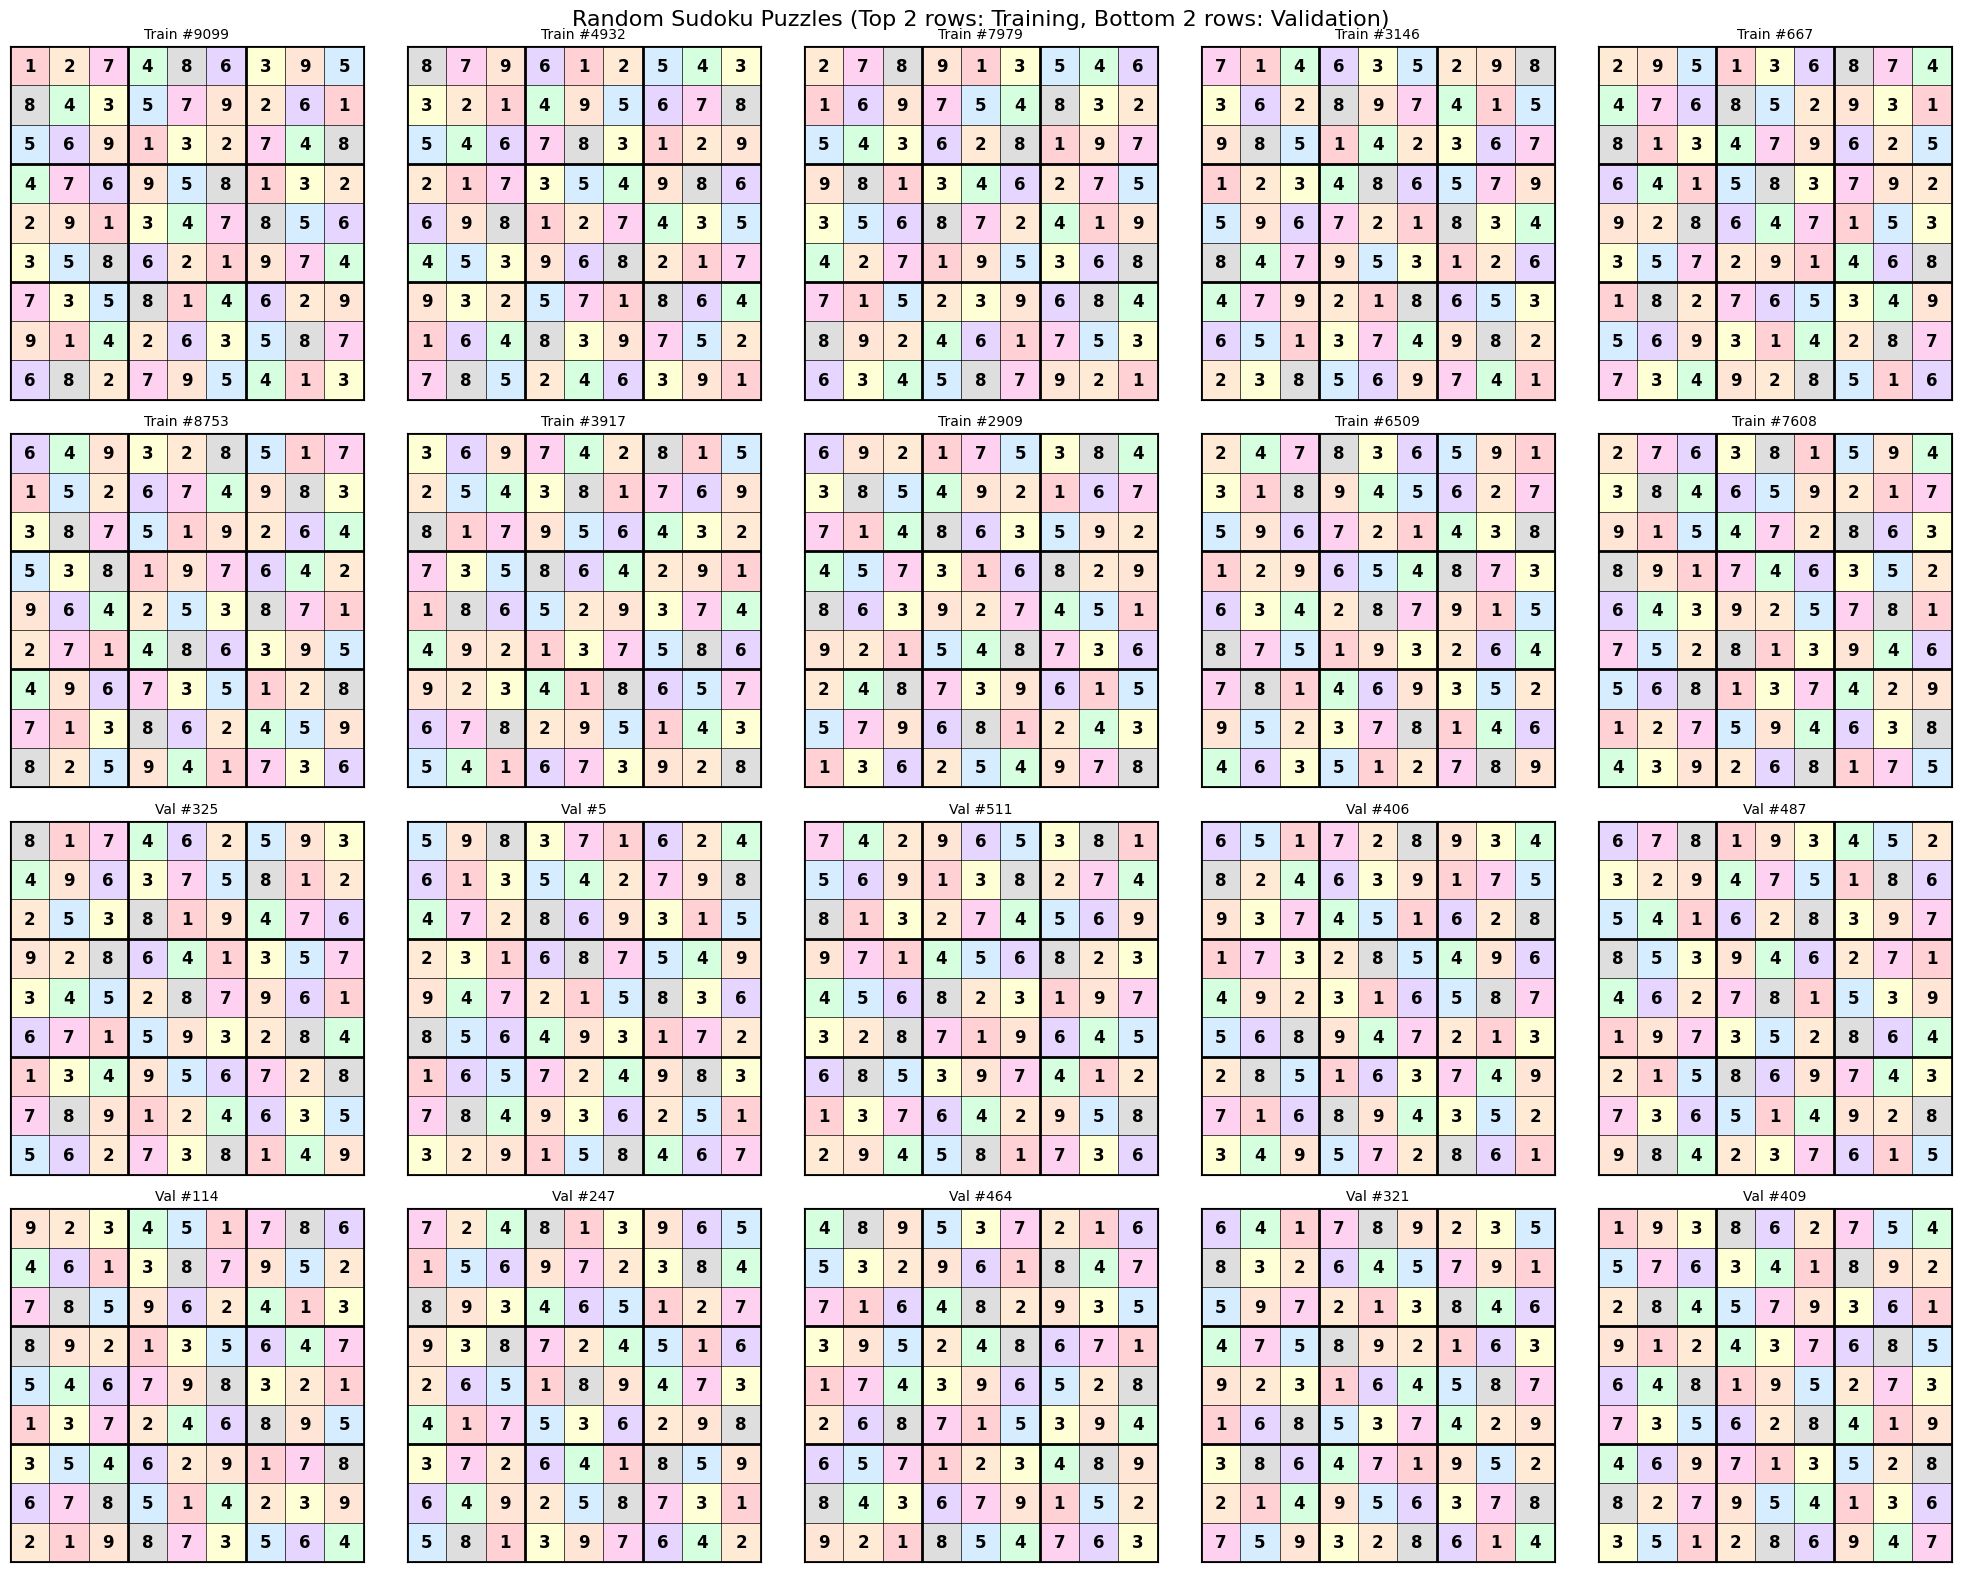

In [ ]:
# Visualize some random sudoku puzzles from training and validation sets
def visualize_sudoku(puzzle, title="Sudoku Puzzle"):
    """Visualize a single sudoku puzzle"""
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Convert to numpy if tensor
    if torch.is_tensor(puzzle):
        puzzle = puzzle.cpu().numpy()
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
    return fig, ax

# Define colors for each number (1-9)
number_colors = {
    1: '#FFB3BA',  # Light red
    2: '#FFDFBA',  # Light orange
    3: '#FFFFBA',  # Light yellow
    4: '#BAFFC9',  # Light green
    5: '#BAE1FF',  # Light blue
    6: '#D4BAFF',  # Light purple
    7: '#FFB3E6',  # Light pink
    8: '#C9C9C9',  # Light gray
    9: '#FFD4BA',  # Light peach
}

# Select 10 random indices from training set
train_indices = np.random.choice(len(puzzles), size=min(10, len(puzzles)), replace=False)

# Select 10 random indices from validation set
val_indices = np.random.choice(len(val_puzzles), size=min(10, len(val_puzzles)), replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Random Sudoku Puzzles (Top 2 rows: Training, Bottom 2 rows: Validation)', fontsize=16)

# Plot training puzzles
for idx, train_idx in enumerate(train_indices):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = puzzles[train_idx].cpu().numpy() if torch.is_tensor(puzzles[train_idx]) else puzzles[train_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Train #{train_idx}', fontsize=10)

# Plot validation puzzles
for idx, val_idx in enumerate(val_indices):
    row = (idx // 5) + 2  # Start from row 2
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = val_puzzles[val_idx].cpu().numpy() if torch.is_tensor(val_puzzles[val_idx]) else val_puzzles[val_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Val #{val_idx}', fontsize=10)

plt.tight_layout()
plt.show()



Starting training from scratch
	Epoch 1/100, Average Loss: 12.0965 Positive Loss:10.9566 Negative Loss:1.1399
	Epoch 2/100, Average Loss: 10.9791 Positive Loss:9.8537 Negative Loss:1.1254
	Epoch 3/100, Average Loss: 9.7965 Positive Loss:8.6904 Negative Loss:1.1061
	Epoch 4/100, Average Loss: 8.8246 Positive Loss:7.7554 Negative Loss:1.0692
	Epoch 5/100, Average Loss: 7.9914 Positive Loss:6.9617 Negative Loss:1.0297
	Epoch 6/100, Average Loss: 7.0857 Positive Loss:6.0950 Negative Loss:0.9907
	Epoch 7/100, Average Loss: 6.4567 Positive Loss:5.5050 Negative Loss:0.9517
	Epoch 8/100, Average Loss: 5.8588 Positive Loss:4.9353 Negative Loss:0.9235
	Epoch 9/100, Average Loss: 5.5165 Positive Loss:4.6128 Negative Loss:0.9038
	Epoch 10/100, Average Loss: 4.9814 Positive Loss:4.0955 Negative Loss:0.8859
	✓ Validation Loss: 4.5867 Positive Loss:3.7094 Negative Loss:0.8774
	✓ Train Accuracy: 0.1094 (10.94%) Val Accuracy: 0.0938 (9.38%)
	💾 Checkpoint saved at epoch 10
	Epoch 11/100, Average Loss: 4

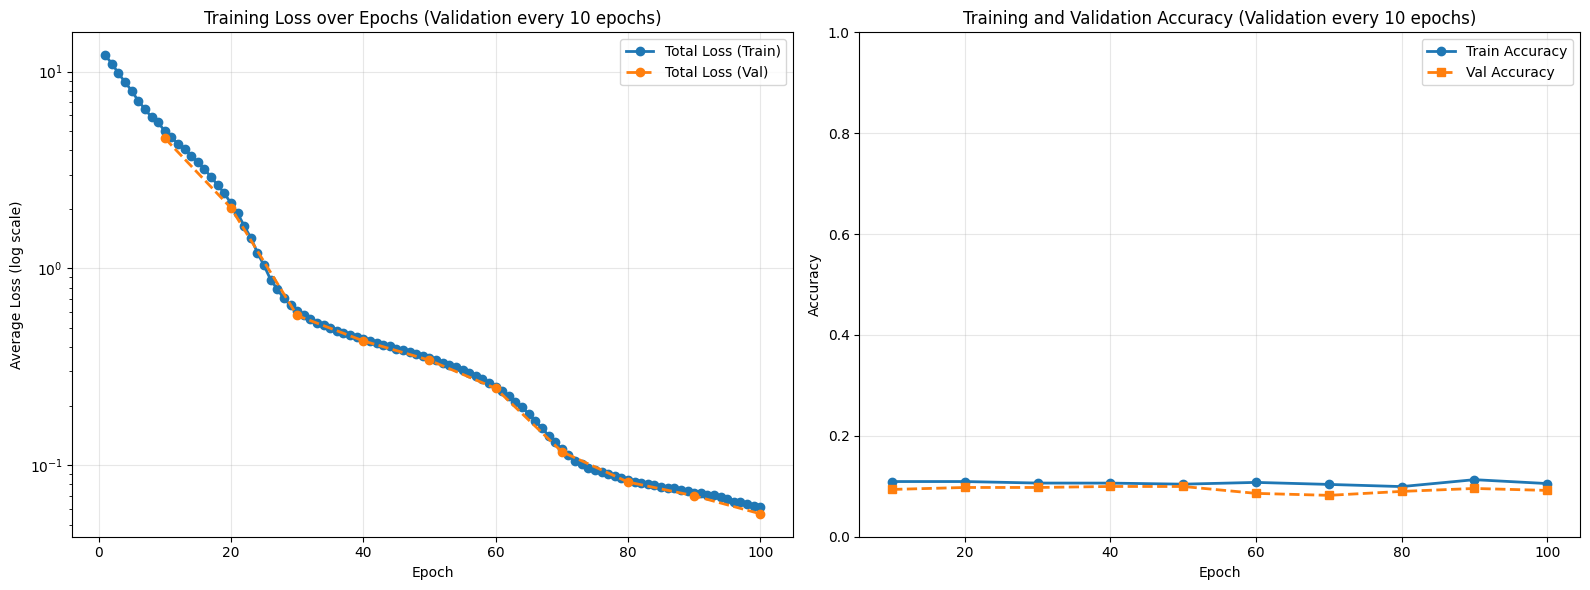

In [ ]:
epoch_losses = []
epoch_positive_losses = []
epoch_negative_losses = []
val_epoch_losses = []
val_epoch_positive_losses = []
val_epoch_negative_losses = []
validation_epochs = []  # Track which epochs we validated on
train_accuracies = []  # Track training accuracies
val_accuracies = []  # Track validation accuracies

# Checkpoint loading
start_epoch = 0
if LOAD_CHECKPOINT and os.path.exists(LOAD_CHECKPOINT):
    print(f"Loading checkpoint from {LOAD_CHECKPOINT}")
    checkpoint = torch.load(LOAD_CHECKPOINT, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    epoch_losses = checkpoint.get('epoch_losses', [])
    epoch_positive_losses = checkpoint.get('epoch_positive_losses', [])
    epoch_negative_losses = checkpoint.get('epoch_negative_losses', [])
    val_epoch_losses = checkpoint.get('val_epoch_losses', [])
    val_epoch_positive_losses = checkpoint.get('val_epoch_positive_losses', [])
    val_epoch_negative_losses = checkpoint.get('val_epoch_negative_losses', [])
    validation_epochs = checkpoint.get('validation_epochs', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    if USE_AMP and scaler is not None:
        scaler.load_state_dict(checkpoint.get('scaler_state_dict', {}))
    
    # Load hyperparameters from checkpoint
    loaded_hp = checkpoint.get('hyperparameters', {})
    print(f"Resuming from epoch {start_epoch}")
    print(f"Loaded hyperparameters: {loaded_hp}")
else:
    print("Starting training from scratch")

for epoch in range(start_epoch, N_EPOCHS):
    epoch_start_time = time.time()
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    epoch_positive_loss = 0.0
    epoch_negative_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = 0
    
    # Loop over batches
    for i in range(0, len(target), BATCH_SIZE):
        # Get batch and ensure it's on the correct device
        batch_target = target[i:i+BATCH_SIZE].long().to(device)
        batch_position = position[i:i+BATCH_SIZE].long().to(device)
        batch_puzzles = puzzles[i:i+BATCH_SIZE].long().to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Mixed precision training with autocast
        if USE_AMP:
            with torch.autocast(device_type=device.type, dtype=amp_dtype):
                # Compute loss
                loss, postive_loss, negative_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Update weights with gradient unscaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training without mixed precision
            loss, postive_loss, negative_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            loss.backward()
            optimizer.step()
        
        # Track loss and accuracy
        batch_size = batch_puzzles.shape[0]
        epoch_loss += loss.item()
        epoch_positive_loss += postive_loss.item()
        epoch_negative_loss += negative_loss.item()
        epoch_correct += (accuracy * batch_size).item()
        epoch_total += batch_size
        num_batches += 1
    
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch statistics
    avg_loss = epoch_loss / num_batches
    avg_positive_loss = epoch_positive_loss / num_batches
    avg_negative_loss = epoch_negative_loss / num_batches
    train_accuracy = epoch_correct / epoch_total
    epoch_losses.append(avg_loss)
    epoch_positive_losses.append(avg_positive_loss)
    epoch_negative_losses.append(avg_negative_loss)
    print(f"\tEpoch {epoch+1}/{N_EPOCHS}, Average Loss: {avg_loss:.4f} Positive Loss:{avg_positive_loss:.4f} Negative Loss:{avg_negative_loss:.4f} Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%) Time: {epoch_time:.2f}s")
    
    # Evaluate on validation set every VALIDATE_PERIOD epochs
    if (epoch + 1) % VALIDATE_PERIOD == 0 or (epoch + 1) == N_EPOCHS:
        val_start_time = time.time()
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_positive_loss = 0.0
        val_negative_loss = 0.0
        val_num_batches = 0
        
        # Store training accuracy for this validation epoch
        train_accuracies.append(train_accuracy)
        
        # Calculate validation accuracy and loss
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            # Also use autocast for validation for consistency
            with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
                for i in range(0, len(val_target), BATCH_SIZE):
                    # Get validation batch and ensure it's on the correct device
                    val_batch_target = val_target[i:i+BATCH_SIZE].long().to(device)
                    val_batch_position = val_position[i:i+BATCH_SIZE].long().to(device)
                    val_batch_puzzles = val_puzzles[i:i+BATCH_SIZE].long().to(device)
                    
                    # Compute validation loss and accuracy
                    loss, postive_loss, negative_loss, accuracy = model.loss(val_batch_target, val_batch_position, val_batch_puzzles)
                    
                    # Track validation loss
                    val_loss += loss.item()
                    val_positive_loss += postive_loss.item()
                    val_negative_loss += negative_loss.item()
                    val_num_batches += 1
                    
                    # Track accuracy
                    batch_size = val_batch_puzzles.shape[0]
                    val_correct += (accuracy * batch_size).item()
                    val_total += batch_size
        
        val_time = time.time() - val_start_time
        
        # Print validation statistics
        avg_val_loss = val_loss / val_num_batches
        avg_val_positive_loss = val_positive_loss / val_num_batches
        avg_val_negative_loss = val_negative_loss / val_num_batches
        val_accuracy = val_correct / val_total
        val_epoch_losses.append(avg_val_loss)
        val_epoch_positive_losses.append(avg_val_positive_loss)
        val_epoch_negative_losses.append(avg_val_negative_loss)
        val_accuracies.append(val_accuracy)
        validation_epochs.append(epoch + 1)
        print(f"\t✓ Validation Loss: {avg_val_loss:.4f} Positive Loss:{avg_val_positive_loss:.4f} Negative Loss:{avg_val_negative_loss:.4f}")
        print(f"\t✓ Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%) Inference Time: {val_time:.2f}s")
    
    # Save checkpoint every CHECKPOINT_PERIOD epochs
    if SAVE_CHECKPOINT and (epoch + 1) % CHECKPOINT_PERIOD == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch_losses': epoch_losses,
            'epoch_positive_losses': epoch_positive_losses,
            'epoch_negative_losses': epoch_negative_losses,
            'val_epoch_losses': val_epoch_losses,
            'val_epoch_positive_losses': val_epoch_positive_losses,
            'val_epoch_negative_losses': val_epoch_negative_losses,
            'validation_epochs': validation_epochs,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'hyperparameters': {
                'N_EPOCHS': N_EPOCHS,
                'LEARNING_RATE': LEARNING_RATE,
                'ATTENTION_DIM': ATTENTION_DIM,
                'N_HEADS': N_HEADS,
                'EMBEDDING_DIM': EMBEDDING_DIM,
                'TRAIN_PUZZLES': TRAIN_PUZZLES,
                'VAL_PUZZLES': VAL_PUZZLES,
                'BATCH_SIZE': BATCH_SIZE,
                'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
            }
        }
        if USE_AMP and scaler is not None:
            checkpoint['scaler_state_dict'] = scaler.state_dict()
        
        checkpoint_path = get_checkpoint_filename(epoch + 1)
        torch.save(checkpoint, checkpoint_path)
        print(f"\t💾 Checkpoint saved at {checkpoint_path}")

# Save final checkpoint
if SAVE_CHECKPOINT:
    checkpoint = {
        'epoch': N_EPOCHS - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch_losses': epoch_losses,
        'epoch_positive_losses': epoch_positive_losses,
        'epoch_negative_losses': epoch_negative_losses,
        'val_epoch_losses': val_epoch_losses,
        'val_epoch_positive_losses': val_epoch_positive_losses,
        'val_epoch_negative_losses': val_epoch_negative_losses,
        'validation_epochs': validation_epochs,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'hyperparameters': {
            'N_EPOCHS': N_EPOCHS,
            'LEARNING_RATE': LEARNING_RATE,
            'ATTENTION_DIM': ATTENTION_DIM,
            'N_HEADS': N_HEADS,
            'EMBEDDING_DIM': EMBEDDING_DIM,
            'TRAIN_PUZZLES': TRAIN_PUZZLES,
            'VAL_PUZZLES': VAL_PUZZLES,
            'BATCH_SIZE': BATCH_SIZE,
            'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
        }
    }
    if USE_AMP and scaler is not None:
        checkpoint['scaler_state_dict'] = scaler.state_dict()
    
    checkpoint_path = get_checkpoint_filename()
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Final checkpoint saved at {checkpoint_path}")

# Plot the loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
ax1.plot(range(1, N_EPOCHS + 1), epoch_losses, marker='o', linestyle='-', linewidth=2, label='Total Loss (Train)')
# ax1.plot(range(1, N_EPOCHS + 1), epoch_positive_losses, marker='s', linestyle='-', linewidth=2, label='Positive Loss (Train)')
# ax1.plot(range(1, N_EPOCHS + 1), epoch_negative_losses, marker='^', linestyle='-', linewidth=2, label='Negative Loss (Train)')

# Plot validation at the epochs where it was actually run
ax1.plot(validation_epochs, val_epoch_losses, marker='o', linestyle='--', linewidth=2, label='Total Loss (Val)')
# ax1.plot(validation_epochs, val_epoch_positive_losses, marker='s', linestyle='--', linewidth=2, label='Positive Loss (Val)')
# ax1.plot(validation_epochs, val_epoch_negative_losses, marker='^', linestyle='--', linewidth=2, label='Negative Loss (Val)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss (log scale)')
ax1.set_title(f'Training Loss over Epochs (Validation every {VALIDATE_PERIOD} epochs)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(validation_epochs, train_accuracies, marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
ax2.plot(validation_epochs, val_accuracies, marker='s', linestyle='--', linewidth=2, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Training and Validation Accuracy (Validation every {VALIDATE_PERIOD} epochs)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [ ]:
def predict_token(model, puzzles, positions, device='cpu'):
    """
    Predict the token at given positions in sudoku puzzles.
    
    Args:
        model: The Sudoku2Vec model
        puzzles: Sudoku grids [batch_size, 9, 9]
        positions: The positions [batch_size, 2] as [x, y]
        device: The device to use for computation
    
    Returns:
        predicted_tokens: The predicted tokens (1-9) based on closest embedding [batch_size]
    """
    model.eval()
    
    with torch.no_grad():
        # Prepare inputs - handle both tensors and arrays
        if isinstance(positions, torch.Tensor):
            position_batch = positions.to(device=device, dtype=torch.long)
        else:
            position_batch = torch.tensor(positions, dtype=torch.long, device=device)
        
        if isinstance(puzzles, torch.Tensor):
            puzzle_batch = puzzles.to(device=device, dtype=torch.long)
        else:
            puzzle_batch = torch.tensor(puzzles, dtype=torch.long, device=device)
        
        batch_size = puzzle_batch.shape[0]
        
        # Create dummy target tokens (we'll ignore these, just need them for forward pass)
        dummy_target = torch.zeros(batch_size, dtype=torch.long, device=device)
        
        # Use the model's forward method
        output, attention, target_token_with_position, _ = model.forward(dummy_target, position_batch, puzzle_batch, mask=True)
        # print(f"DEBUG: output.shape = {output.shape}")
        # print(f"DEBUG: attention.shape = {attention.shape}")
        # print(f"DEBUG: target_token_with_position.shape = {target_token_with_position.shape}")
        
        # Get the attended output at the target position
        # We need to extract the embedding at the target position from the output
        target_indices = position_batch[:, 1] * 9 + position_batch[:, 0]  # Convert 2D position to 1D index
        # # print(f"DEBUG: target_indices = {target_indices}")
        predicted_embedding = output[torch.arange(batch_size, device=device), target_indices]  # [batch_size, total_dim]
        # print(f"DEBUG: predicted_embedding.shape = {predicted_embedding.shape}")
        
        # Get all token embeddings (0-9)
        all_tokens = torch.arange(0, 10, dtype=torch.long, device=device)
        all_token_embeddings = model.embed(all_tokens)  # [10, embedding_dim]
        # print(f"DEBUG: all_token_embeddings.shape = {all_token_embeddings.shape}")
        # print(f"DEBUG: model.embedding_dim = {model.embedding_dim}")
        
        # Extract only the token embedding part (exclude position info)
        # predicted_embedding is [batch_size, total_dim] where total_dim = embedding_dim + 2
        # We only want the first embedding_dim dimensions
        predicted_token_part = predicted_embedding[:, :model.embedding_dim]  # [batch_size, embedding_dim]
        
        # Find closest embedding using cosine similarity
        # Normalize embeddings
        predicted_embedding_norm = torch.nn.functional.normalize(predicted_token_part, p=2, dim=-1)  # [batch_size, embedding_dim]
        all_token_embeddings_norm = torch.nn.functional.normalize(all_token_embeddings, p=2, dim=-1)  # [10, embedding_dim]
        
        # Compute cosine similarity
        similarities = torch.matmul(predicted_embedding_norm, all_token_embeddings_norm.T)  # [batch_size, 10]
        predicted_tokens = torch.argmax(similarities, dim=-1)  # tokens are 0-9, [batch_size]
        
        return predicted_tokens


# Test model accuracy

tensor([7, 4, 4, 3, 9, 3, 2, 2, 5, 5, 8, 8, 5, 6, 8, 5, 3, 9, 2, 2, 3, 3, 4, 6,
        1, 3, 4, 8, 5, 8, 3, 5, 2, 1, 5, 2, 9, 2, 2, 1, 6, 1, 4, 5, 7, 3, 6, 9,
        4, 9, 7, 7, 8, 1, 6, 3, 9, 2, 8, 2, 1, 3, 4, 1, 4, 9, 5, 6, 8, 6, 8, 2,
        3, 5, 6, 6, 5, 1, 1, 8, 2, 7, 9, 2, 4, 9, 4, 9, 6, 4, 5, 6, 9, 3, 1, 7,
        6, 9, 2, 8], device='mps:0', dtype=torch.int8)
Validation Accuracy: 0.1200 (12.00%)
Correct: 12/100


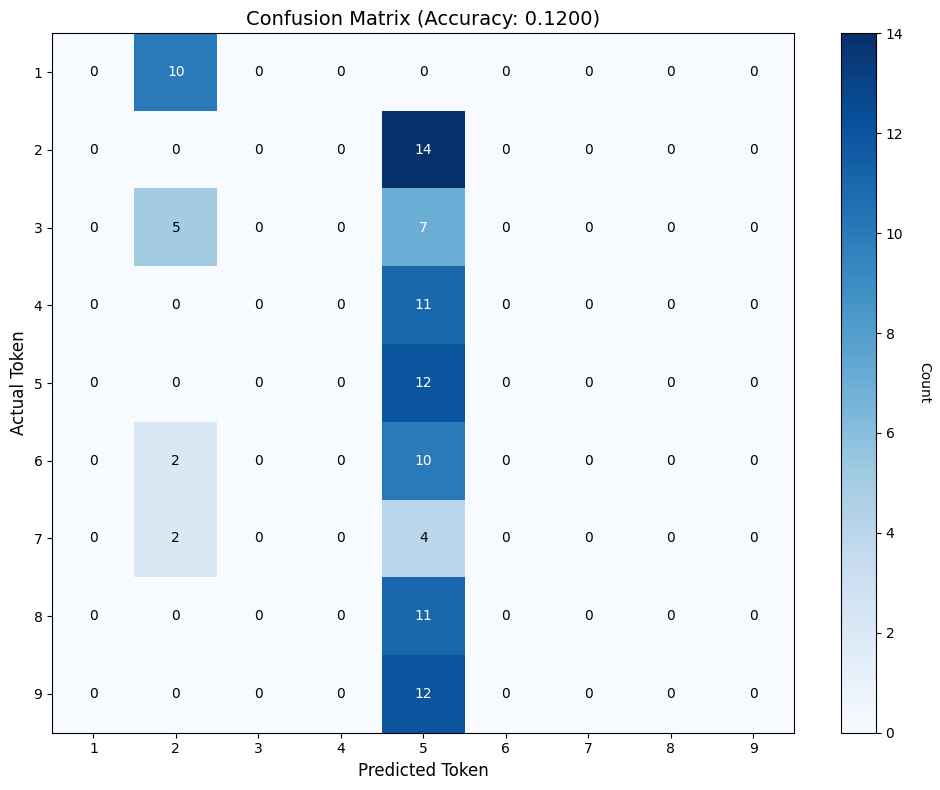

In [ ]:
# Get predictions for all validation samples in batch
TEST_SIZE = 100
test_target, test_position, test_puzzles, test_original_puzzle = generator.generate_target_context_pairs(size=TEST_SIZE)
print(test_target)
all_predictions = predict_token(model, test_puzzles, test_position, device=device)

# Get actual values at the positions
all_actuals = []
for i in range(len(test_puzzles)):
    pos_x, pos_y = test_position[i][0].item(), test_position[i][1].item()
    actual_token = test_puzzles[i][pos_y, pos_x].item()
    all_actuals.append(actual_token)

all_actuals = torch.tensor(all_actuals, device=device)

# Calculate accuracy
correct = (all_predictions == all_actuals).sum().item()
total = len(all_predictions)
accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Correct: {correct}/{total}")

# Create confusion matrix manually
# Tokens are 1-9
cm = np.zeros((9, 9), dtype=int)
all_predictions_cpu = all_predictions.cpu().numpy()
all_actuals_cpu = all_actuals.cpu().numpy()

for actual, pred in zip(all_actuals_cpu, all_predictions_cpu):
    cm[actual - 1, pred - 1] += 1

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', rotation=270, labelpad=20)

# Set ticks and labels
ax.set_xticks(np.arange(9))
ax.set_yticks(np.arange(9))
ax.set_xticklabels(list(range(1, 10)))
ax.set_yticklabels(list(range(1, 10)))

# Add text annotations
for i in range(9):
    for j in range(9):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="black" if cm[i, j] < cm.max() / 2 else "white")

# Labels and title
ax.set_xlabel('Predicted Token', fontsize=12)
ax.set_ylabel('Actual Token', fontsize=12)
ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.4f})', fontsize=14)

plt.tight_layout()
plt.show()


=== Visualizing Attention ===
Puzzle:
[[1 8 6 9 5 3 7 4 2]
 [2 3 4 8 6 7 5 9 1]
 [7 5 9 1 2 4 3 8 6]
 [8 6 2 7 9 5 4 1 3]
 [5 7 1 4 3 8 2 6 9]
 [9 4 3 2 1 6 8 7 5]
 [3 2 7 6 8 1 9 5 4]
 [6 9 8 5 4 2 1 3 7]
 [4 1 5 3 7 9 6 2 8]]
Target: 3 at position [4 4]


/var/folders/06/9qrhxzd12j19fybr2l6xdv_h0000gn/T/ipykernel_39036/3070034613.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  position_batch = torch.tensor(positions, dtype=torch.long, device=device)
W1029 16:26:05.479000 39036 torch/_inductor/utils.py:1436] [0/1] Not enough SMs to use max_autotune_gemm mode


Predicted: 1, Actual: 3
Attention sums per head: [1.]


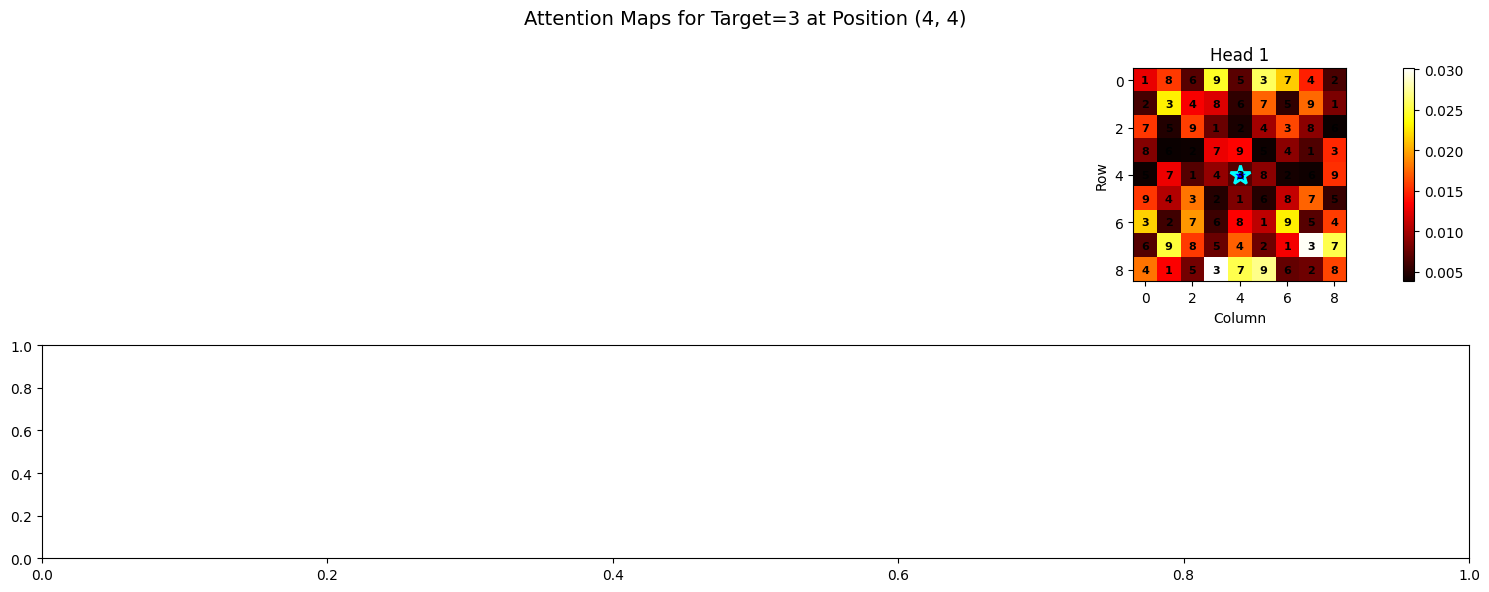

In [ ]:
def visualize_attention(model, puzzle, target, position, device='cpu'):
    """
    Visualize the attention weights for each head in the model.
    
    Args:
        model: The Sudoku2Vec model
        puzzle: A single sudoku grid [9, 9]
        target: The target token (scalar)
        position: The position [2] as [x, y]
        device: The device to use for computation
    """
    model.eval()
    
    with torch.no_grad():
        # Prepare inputs (add batch dimension)
        target_batch = torch.tensor([target], dtype=torch.long, device=device)
        position_batch = torch.tensor([position], dtype=torch.long, device=device)
        puzzle_batch = torch.tensor([puzzle], dtype=torch.long, device=device)
        
        # Get embeddings
        batch_size = 1
        target_token_embeddings = model.embed(target_batch)
        target_position_vectors = model.pe.get_embedding_for_position(position_batch)
        target_token_with_position = torch.cat([target_token_embeddings, target_position_vectors], dim=-1)
        
        # Mask the target in the grid
        sudoku_grid_masked = puzzle_batch.clone()
        sudoku_grid_masked[0, position[1], position[0]] = 0
        
        # Get grid embeddings
        sudoku_grid_embeddings = model.embed(sudoku_grid_masked)
        sudoku_grid_with_position = model.pe(sudoku_grid_embeddings)
        
        # Reshape grid to sequence
        grid_seq = sudoku_grid_with_position.view(batch_size, 81, model.total_dim)
        
        # Get attention weights from the model
        _, attention = model.mha(grid_seq, return_attention=True)
        
        # Reshape attention weights to grid format
        # attention shape is [batch, num_heads, seq_len, seq_len]
        # Get the attention for the specific position (x, y)
        position_idx = position[1] * 9 + position[0]  # Convert 2D position to 1D index
        attention_weights = attention.squeeze(0)[:, position_idx, :]  # [num_heads, 81]
        
        # Validate that attention sums to 1 for each head
        attention_sums = attention_weights.sum(dim=-1)
        print(f"Attention sums per head: {attention_sums.cpu().numpy()}")
        assert torch.allclose(attention_sums, torch.ones_like(attention_sums), atol=1e-5), \
            f"Attention weights do not sum to 1! Sums: {attention_sums}"
        
        attention_grids = attention_weights.view(model.num_heads, 9, 9).cpu().numpy()
        # Plot attention maps for each head
        fig, axes = plt.subplots(2, (model.num_heads + 1) // 2, figsize=(15, 6))
        axes = axes.flatten()
        
        for head_idx in range(model.num_heads):
            ax = axes[head_idx]
            im = ax.imshow(attention_grids[head_idx], cmap='hot', interpolation='nearest')
            ax.set_title(f'Head {head_idx + 1}')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            
            # Add grid values as text
            for i in range(9):
                for j in range(9):
                    text_color = 'white' if attention_grids[head_idx, i, j] > 0.5 else 'black'
                    ax.text(j, i, f'{puzzle[i, j]}', ha='center', va='center', 
                           color=text_color, fontsize=8, weight='bold')
            
            # Mark target position
            ax.plot(position[0], position[1], 'b*', markersize=15, markeredgecolor='cyan', markeredgewidth=2)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        plt.suptitle(f'Attention Maps for Target={target} at Position ({position[0]}, {position[1]})', fontsize=14)
        plt.tight_layout()
        plt.show()

# Example usage
example_idx = random.randint(0, 100)
example_puzzle = val_puzzles[example_idx].cpu().numpy()
example_target = val_target[example_idx].item()
example_position = val_position[example_idx].cpu().numpy()

print(f"\n=== Visualizing Attention ===")
print(f"Puzzle:\n{example_puzzle}")
print(f"Target: {example_target} at position {example_position}")

# Get prediction
predicted_token = predict_token(model, [example_puzzle], [example_position], device=device)[0].item()
print(f"Predicted: {predicted_token}, Actual: {example_target}")

visualize_attention(model, example_puzzle, example_target, example_position, device=device)
